In [426]:
#all of the import statements
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import matplotlib
from math import log
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
'''replace NAs with given value'''
def clean_nas(stations, fillVal):
    naIndices = stations.index[stations['Total Docks'].isna()].tolist()
    for ii in naIndices:
        stations['Total Docks'][ii] = fillVal
    return stations

In [ ]:
'''returns dictionary with info on each station in the dataset, the average total docks per station, and the values that each station should be updated to if their capacity leaves the reasonable range'''
def make_station_info_dict(trip_data, station_data1):
    
    averageCap = 15 ###the mean and median of total dock space is 17 but this is round
    fullAdjustment = 9*(averageCap/11)  ####subtract this from the total and vv
    emptyAdjustment = 9*(averageCap/11)
    
    station_data = clean_nas(station_data1, fillVal = averageCap)
    
    ##makes dictionary of station info based on info present in stations data file
    stationInfo = {stations['NAME'][ii]: {'Total Capacity': int(stations['Total Docks'][ii])} for ii in range(len(stations))}
   

    for station in list(stationInfo): ##originally this was calculated after the dictionary was made
            if (station in set(trip_data['start_station_name'])): #|(station in set(trip_data['end_station_name'])
                #catching stations that don't actually occur in data
                stationInfo[station]['Full Adjustment'] = 9*(stationInfo[station]['Total Capacity'])/11
                stationInfo[station]['Empty Adjustment'] =  9*(stationInfo[station]['Total Capacity'])/11
                stationInfo[station]['Current Capacity'] = 4*(stationInfo[station]['Total Capacity']/7) ## this makes the total amount of bikes in the system at start just under 5000
                stationInfo[station]['Times Empty'] = 0
                stationInfo[station]['Times Full'] =  0
                stationInfo[station]['Total Rides'] = 0
                stationInfo[station]['Member Rides'] = 0
                stationInfo[station]['Electric Bike IN'] = 0
                stationInfo[station]['Electric Bike OUT'] = 0
                stationInfo[station]['Electric Bike and Member Rides'] = 0
            else:
                del stationInfo[station]

        ##adds stations in trip_data that are not in station_data
    for station in (trip_data['start_station_name']):
        if station not in stationInfo:
            stationInfo[station] = create_station_entry(station, averageCap, fullAdjustment, emptyAdjustment)
    for station in (trip_data['end_station_name']):
        if station not in stationInfo:
            stationInfo[station] = create_station_entry(station, averageCap, fullAdjustment, emptyAdjustment)

    #print(f' starting cap: {sum([stationInfo[station]["Current Capacity"] for station in stationInfo])}')
    return stationInfo, averageCap, fullAdjustment, emptyAdjustment

In [429]:
'''takes in all columns of dataset, 
returns dataset with additional column of  bikes at each station after trip
 -- returns updated dataset (and station info dictionary for testing)'''

def calc_bike_count(trip_data, stations):
    stationInfo, averageCap, fullAdjustment, emptyAdjustment = make_station_info_dict(trip_data, stations)

    for ii in range(0, len(trip_data)): #iterate through rows (each trip) in dataset
        row = trip_data.iloc[ii]
        start_station = row['start_station_name']
        end_station = row['end_station_name']
        
        if row['rideable_type'] == 'electric_bike':
            stationInfo[end_station]['Electric Bike IN'] += 1
            stationInfo[start_station]['Electric Bike OUT'] += 1
            if row['member_casual'] == 'member':    
                stationInfo[start_station]['Electric Bike and Member Rides'] += 1 ##this is just start station for now
        if row['member_casual'] == 'member':
            stationInfo[start_station]['Member Rides'] += 1
        
        stationInfo[start_station]['Total Rides'] += 1
        stationInfo[start_station]['Current Capacity'] -=1  
        stationInfo[end_station]['Current Capacity'] += 1
            
        if stationInfo[start_station]['Current Capacity'] < 0: ### adjust to be within correct bounds
            stationInfo[start_station]['Current Capacity'] = stationInfo[start_station]["Empty Adjustment"] 
            stationInfo[start_station]['Times Empty'] += 1

        if stationInfo[end_station]['Current Capacity'] > stationInfo[end_station]['Total Capacity']:
            stationInfo[end_station]['Current Capacity'] = (stationInfo[start_station]["Total Capacity"] - stationInfo[end_station]['Full Adjustment'])
            stationInfo[end_station]['Times Full'] += 1
    
        trip_data.at[ii, 'start_station_capacity'] =  stationInfo[start_station]['Current Capacity'] ## add to trip data
        trip_data.at[ii, 'end_station_capacity'] = stationInfo[end_station]['Current Capacity']

    return trip_data, stationInfo

In [430]:
def create_station_entry(station, averageCap, fullAdjustment, emptyAdjustment): ## this is still being called in the function above for some entries
 ### creates station dictionary entry with average stats
        return{'Total Capacity': averageCap, 'Current Capacity': 9, 
        'Full Adjustment': fullAdjustment, 'Empty Adjustment': emptyAdjustment, 
        'Times Empty': 0, 'Times Full': 0, 'Total Rides': 0, 'Member Rides': 0, 
        'Electric Bike IN':0, 'Electric Bike OUT': 0, 
        'Electric Bike and Member Rides': 0}

In [431]:
#return list of the capacity target station for every ride that starts there
def make_capacity_over_time(trip_data, target_station):
    cap_list = []
    date_time_list = []
    for ii in range(0, len(trip_data)):
        if (trip_data.at[ii, 'start_station_name']== target_station):
            cap_list.append(trip_data.at[ii, 'start_station_capacity'])
            date_time_list.append(trip_data.at[ii, 'started_at'])#date_time_list.append(ii)#date_time_list.append(trip_data.at[ii, 'started_at'])
        elif (trip_data.at[ii, 'end_station_name']== target_station):
            cap_list.append(trip_data.at[ii, 'end_station_capacity'])
            date_time_list.append(trip_data.at[ii, 'started_at']) #date_time_list.append(ii)#date_time_list.append(trip_data.at[ii, 'started_at'])

    return cap_list, date_time_list

In [432]:
## drops keys from station dictionary not to be used as features
def get_model_features(stationDict):
    feats = pd.DataFrame.from_dict(stationDict, orient = 'index')
    feats = feats.drop('Total Rides', axis = 1)
    feats = feats.drop('Member Rides', axis = 1)
    feats = feats.drop('Electric Bike and Member Rides', axis = 1)
    feats = feats.drop('Full Adjustment', axis = 1)
    feats = feats.drop('Empty Adjustment', axis = 1)
    feats = feats.drop('Current Capacity', axis = 1)
    feats = feats.drop('Electric Bike IN', axis = 1)
    feats = feats.drop('Electric Bike OUT', axis = 1)
    return feats

In [ ]:
## calculates proportion of rides taken by electric bikes out of total from station
def add_prop_electric_feat(feats, trip_data):
    for station in feats.index:
        trips = trip_data.loc[trip_data['start_station_name'] == station]
        feats.loc[station, 'total trips'] = len(trips) ## total trips at station in month

        electricRides = trips.loc[trips['rideable_type'] == 'electric_bike']
        if len(trips) == 0:
            propElectric = 0

        else:
            propElectric = len(electricRides)/len(trips)
        
        feats.loc[station, 'propElectric'] = propElectric
    return feats

In [ ]:
## calculates proportion of rides from a station out of total rides in the month
def add_prop_total_rides_feat(feats, trip_data):
    total_trips = len(trip_data)
    for station in feats.index:
        station_trips = len(trip_data.loc[trip_data['start_station_name'] == station])

        if station_trips == 0:
            propTrips = 0

        else:
            propTrips = station_trips/total_trips
        
        feats.loc[station, 'propTrips'] = propTrips
    return feats    

In [434]:
## calculates proportion of member rides to total
def get_labels(stationsDict):
    labels = []
    for station in stationsDict:
        if (stationsDict[station]['Total Rides']) == 0:
            label = 0
        else:
            label = (stations1[station]['Member Rides'])/(stations1[station]['Total Rides'])
        labels.append(label)
    return labels

In [435]:
# linear regression
def run_linear_model(feats, labels):
    #print(feats, labels)
    X_train, X_test, y_train, y_test = train_test_split(feats, labels, test_size=0.20, random_state=0)

    linearReg = LinearRegression()
    linearReg.fit(X_train, y_train)
    score = linearReg.score(X_test, y_test)
    preds = linearReg.predict(X_test)
    weights = linearReg.coef_

    return score, preds, weights , X_test, y_test

In [436]:
def log_function(feat):
    return [log(x) if x > 0 else x for x in feat]

In [437]:
def log_feats(current_feats, logfeats):
    for feat in logfeats:
        #print(feat)
        #print(current_feats[feat])
        current_feats[f"log {feat}"] = log_function(current_feats[feat])
    return current_feats

In [ ]:
def add_interaction(feats): ###add interaction terms -- not used in final code
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    return pd.DataFrame(poly.fit_transform(feats))

In [439]:
##run quietly
import warnings
warnings.filterwarnings("ignore")

In [ ]:
###loading data
trip_data_7_24= pd.read_csv('C:/Python/pythonfall24/202407-bluebikes-tripdata.csv')
stations = pd.read_csv("C:/Python/pythonfall24/current_bluebikes_stations.csv", header =1)

trip_data, stations1 = calc_bike_count(trip_data_7_24, stations)

In [ ]:
# get feats for model predicting propMembers
loggedFeats = ["Times Empty", "Times Full", "Total Capacity", "total trips", 'propTrips']
current_feats = get_model_features(stations1)
current_feats = add_prop_electric_feat(current_feats, trip_data)
current_feats = add_prop_total_rides_feat(current_feats, trip_data)
current_feats = log_feats(current_feats, loggedFeats)
#feats = add_interaction(current_feats)

In [522]:
##running model
current_labels = get_labels(stations1)
scoreM, preds, weightsM, X_test, y_test = run_linear_model(current_feats, current_labels)

In [ ]:
''' plots for propMembers prediciton model vvv'''

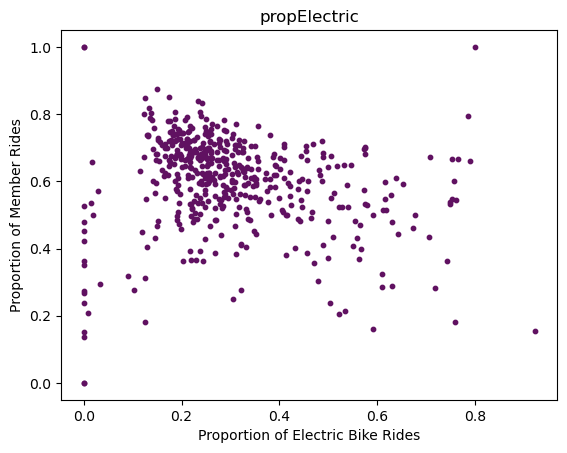

In [446]:
#%matplotlib inline
ax2 = plt.subplot(111)
ax2.scatter(current_feats['propElectric'], current_labels, label = 'actual', marker = 'o', color = '#601161', s = 10)
plt.xlabel('Proportion of Electric Bike Rides')
plt.ylabel('Proportion of Member Rides')
plt.title('propElectric')
#plt.xticks(rotation=90, fontsize = 2)
#plt.legend()
ax2.figure.show()

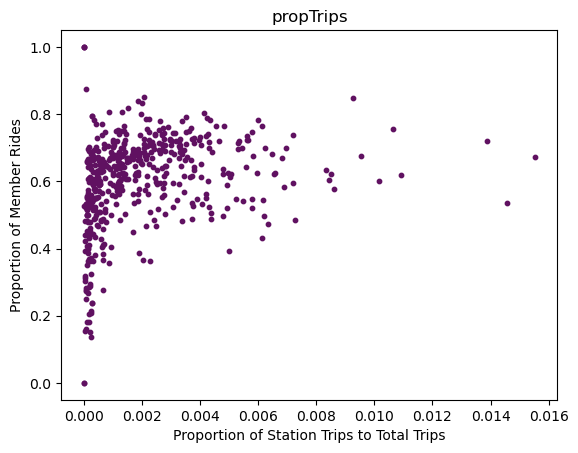

In [527]:
ax2 = plt.subplot(111)
ax2.scatter(current_feats['propTrips'], current_labels, label = 'actual', marker = 'o', color = '#601161', s = 10) ### log

plt.title('propTrips')
plt.xlabel('Proportion of Station Trips to Total Trips')
plt.ylabel('Proportion of Member Rides')
#plt.xticks(rotation=90, fontsize = 2)
#plt.legend()
ax2.figure.show()

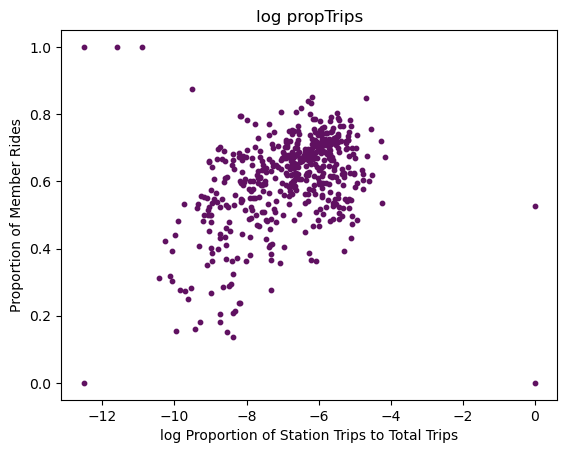

In [528]:
ax2 = plt.subplot(111)
ax2.scatter(current_feats['log propTrips'], current_labels, label = 'actual', marker = 'o', color = '#601161', s = 10) ### log

plt.title('log propTrips')
plt.xlabel('log Proportion of Station Trips to Total Trips')
plt.ylabel('Proportion of Member Rides')
#plt.xticks(rotation=90, fontsize = 2)
#plt.legend()
ax2.figure.show()

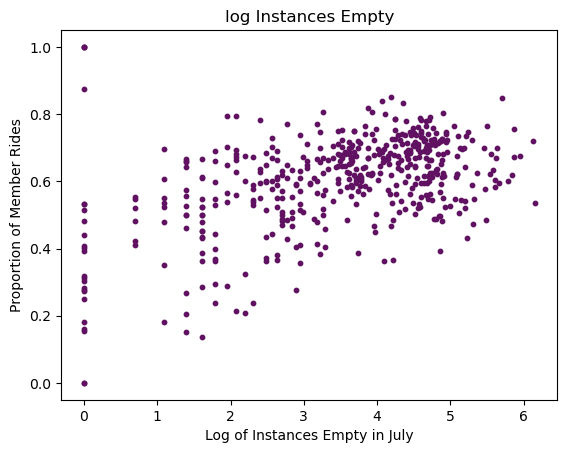

In [530]:
#%matplotlib inline
ax2 = plt.subplot(111)
ax2.scatter(current_feats['log Times Empty'], current_labels, label = 'actual', marker = 'o', color = '#601161', s = 10) ### log

plt.title('log Instances Empty')
plt.xlabel('Log of Instances Empty in July')
plt.ylabel('Proportion of Member Rides')
#plt.xticks(rotation=90, fontsize = 2)
#plt.legend()
ax2.figure.show()

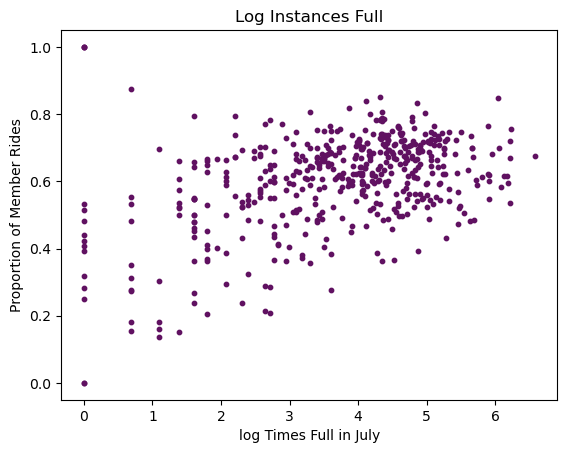

In [531]:
#%matplotlib inline
ax2 = plt.subplot(111)
ax2.scatter(current_feats['log Times Full'], current_labels, label = 'actual', marker = 'o', color = '#601161', s = 10)

plt.title('Log Instances Full')
plt.xlabel('log Times Full in July')
plt.ylabel('Proportion of Member Rides')
#plt.xticks(rotation=90, fontsize = 2)
#plt.legend()
ax2.figure.show()

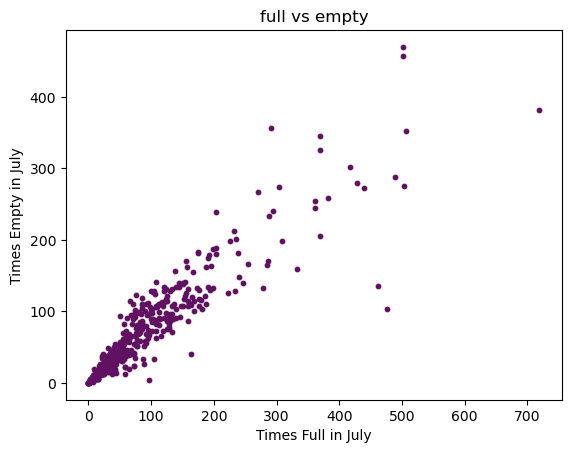

In [451]:
#%matplotlib inline
ax2 = plt.subplot(111)
ax2.scatter(current_feats['Times Full'], current_feats['Times Empty'], label = 'actual', marker = 'o', color = '#601161', s = 10)

plt.title('full vs empty')
plt.xlabel('Times Full in July')
plt.ylabel('Times Empty in July')
#plt.xticks(rotation=90, fontsize = 2)
#plt.legend()
ax2.figure.show()

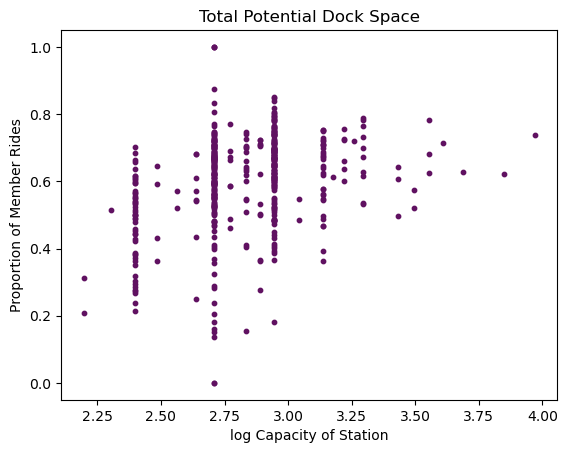

In [532]:
#%matplotlib inline
ax2 = plt.subplot(111)
ax2.scatter(current_feats['log Total Capacity'], current_labels, label = 'actual', marker = 'o', color = '#601161', s = 10)

plt.title('Total Potential Dock Space')
plt.xlabel('log Capacity of Station')
plt.ylabel('Proportion of Member Rides')
#plt.xticks(rotation=90, fontsize = 2)
#plt.legend()
ax2.figure.show()

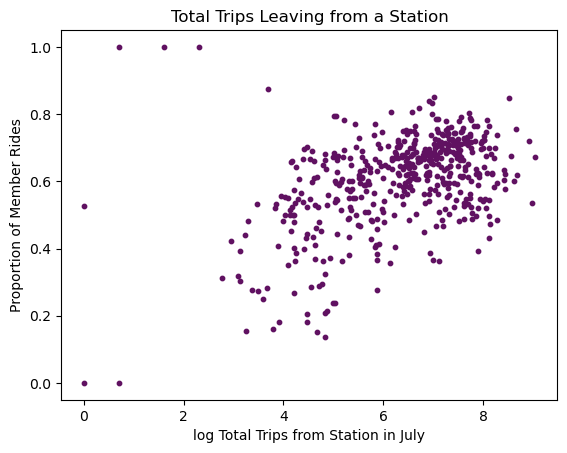

In [453]:
#%matplotlib inline
ax2 = plt.subplot(111)
ax2.scatter(current_feats['log total trips'], current_labels, label = 'actual', marker = 'o', color = '#601161', s = 10)

plt.title('Total Trips Leaving from a Station')
plt.xlabel('log Total Trips from Station in July')
plt.ylabel('Proportion of Member Rides')
#plt.xticks(rotation=90, fontsize = 2)
#plt.legend()
ax2.figure.show()

In [ ]:
### updating features for model proedicting proportion of rides from a station
feats2 = current_feats.copy()
feats2['propMembers'] = current_labels
labels2 = feats2['log propTrips']
feats2 = feats2.drop('total trips', axis = 1)
feats2 = feats2.drop('log total trips', axis = 1)
#feats2 = feats2.drop('log Times Empty', axis = 1)
#feats2 = feats2.drop('log Times Full', axis = 1)
#feats2 = feats2.drop('log Total Capacity', axis = 1)
feats2 = feats2.drop('log propTrips', axis = 1)
feats2 = feats2.drop('propTrips', axis = 1)

In [503]:
score, preds, weights, X_test, y_test = run_linear_model(feats2, labels2)

In [ ]:
'''plots for propRides model vvv'''

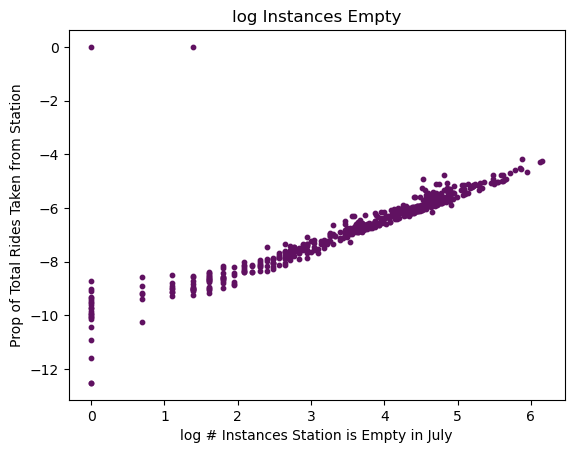

In [515]:
#%matplotlib inline
ax2 = plt.subplot(111)
ax2.scatter(feats2['log Times Empty'], labels2, label = 'actual', marker = 'o', color = '#601161', s = 10)

plt.title('log Instances Empty')
plt.xlabel('log # Instances Station is Empty in July')
plt.ylabel('Prop of Total Rides Taken from Station')
#plt.xticks(rotation=90, fontsize = 2)
#plt.legend()
ax2.figure.show()

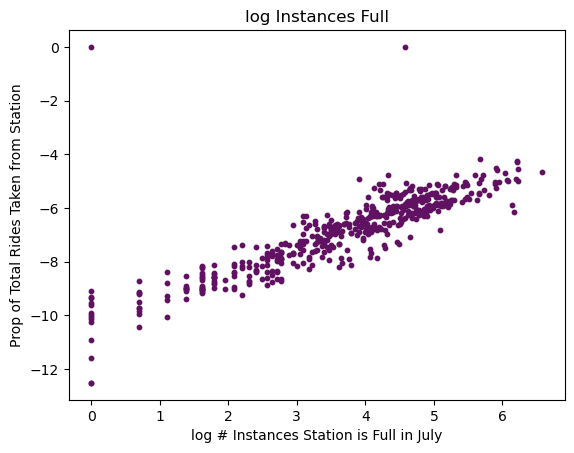

In [516]:
ax2 = plt.subplot(111)
ax2.scatter(feats2['log Times Full'], labels2, label = 'actual', marker = 'o', color = '#601161', s = 10)

plt.title('log Instances Full')
plt.xlabel('log # Instances Station is Full in July')
plt.ylabel('Prop of Total Rides Taken from Station')
#plt.xticks(rotation=90, fontsize = 2)
#plt.legend()
ax2.figure.show()

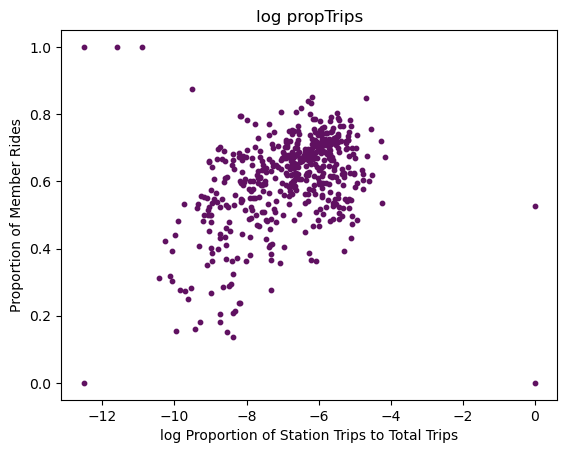

In [495]:
ax2 = plt.subplot(111)
ax2.scatter(current_feats['log propTrips'], current_labels, label = 'actual', marker = 'o', color = '#601161', s = 10) ### log

plt.title('log propTrips')
plt.xlabel('log Proportion of Station Trips to Total Trips')
plt.ylabel('Proportion of Member Rides')
#plt.xticks(rotation=90, fontsize = 2)
#plt.legend()
ax2.figure.show()

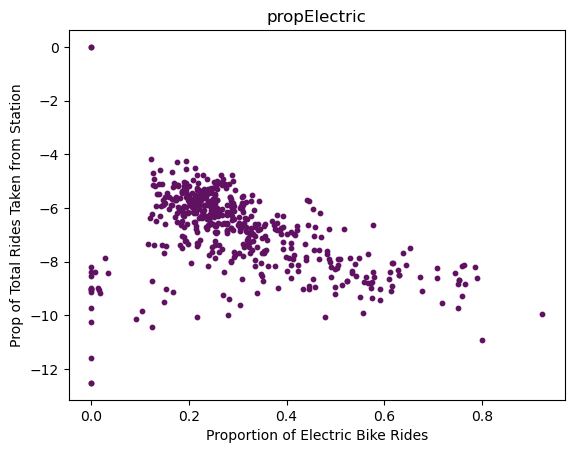

In [533]:
ax2 = plt.subplot(111)
ax2.scatter(feats2['propElectric'], labels2, label = 'actual', marker = 'o', color = '#601161', s = 10)

plt.title('propElectric')
plt.xlabel('Proportion of Electric Bike Rides')
plt.ylabel('Prop of Total Rides Taken from Station')
#plt.xticks(rotation=90, fontsize = 2)
#plt.legend()
ax2.figure.show()

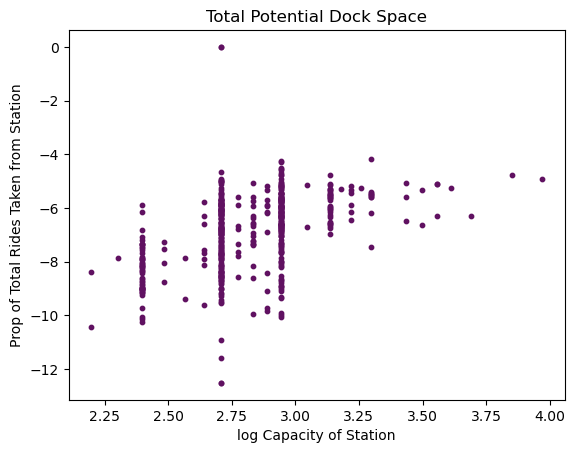

In [534]:
ax2 = plt.subplot(111)
ax2.scatter(feats2['log Total Capacity'], labels2, label = 'actual', marker = 'o', color = '#601161', s = 10)

plt.title('Total Potential Dock Space')
plt.xlabel('log Capacity of Station')
plt.ylabel('Prop of Total Rides Taken from Station')
#plt.xticks(rotation=90, fontsize = 2)
#plt.legend()
ax2.figure.show()

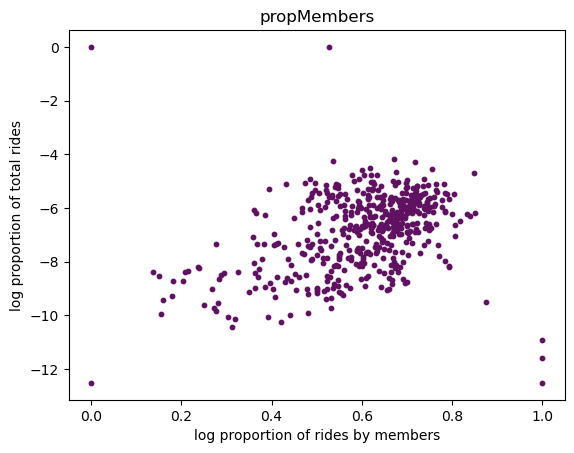

In [512]:
ax2 = plt.subplot(111)
ax2.scatter(feats2['propMembers'], labels2, label = 'actual', marker = 'o', color = '#601161', s = 10)

plt.title('propMembers')
plt.xlabel('log proportion of rides by members')
plt.ylabel('log proportion of total rides')
#plt.xticks(rotation=90, fontsize = 2)
#plt.legend()
ax2.figure.show()

In [ ]:
from plotnine import * ##different plotting package

In [ ]:
'''example plots of information from capacity calculation in calc_bike_count() vvv'''

In [ ]:
kendall_cap_list, date_time_list = make_capacity_over_time(trip_data, "Kendall T")
l = [date.split(' ')[1][0:-4] for date in date_time_list] ## shorter date time labels for each ride

In [ ]:
plot1 =( (ggplot(aes(x = l[0:100], y = kendall_cap_list[0:100])) + geom_line(group = 1, color = '#8A2BE2') + geom_hline(yintercept = [0, stations1['Kendall T']['Total Capacity']], color = '#006400') + geom_hline(yintercept = [(stations1['Kendall T']["Total Capacity"]-stations1['Kendall T']['Full Adjustment']), stations1['Kendall T']['Empty Adjustment']], linetype = 'dashed') + labs(x = 'Ride', y = 'Capacity', title = 'Capacity of Kendall T Dock (first 100 rides in July 2024)') + theme(axis_text_x = element_text(angle = 80, va = 'top', ha = 'right', rotation_mode = 'anchor', size = 4))).draw() )

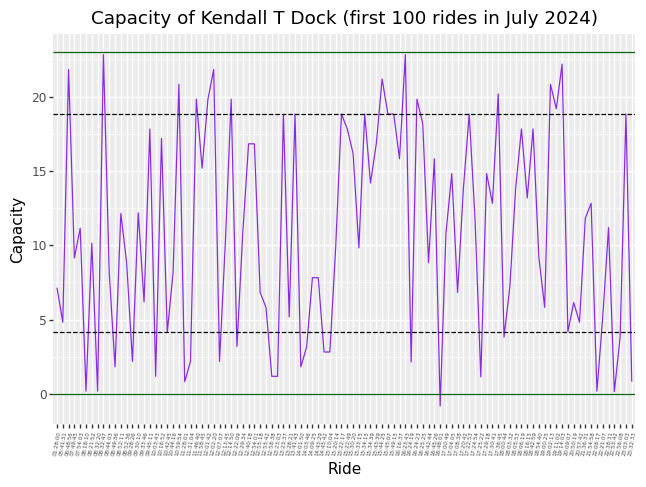

In [ ]:
plot1
#Dark green solid lines: max and min capacity, black dotted line: value adjusted to to keep capacity in a logical range. (not included on graph for space)

In [ ]:
seaport = 'South Station - 700 Atlantic Ave' ###sorry i didn't change this variable name bc its everywhere now but south station was a better example than the seaport stations
seaport_cap_list, seaport_date_time_list = make_capacity_over_time(trip_data, seaport)
seaport_short_date = [date.split(' ')[1][0:-4] for date in seaport_date_time_list]
plot2 =( (ggplot(aes(x = seaport_short_date[0:100], y = seaport_cap_list[0:100])) + geom_line(group = 1, color = '#8A2BE2') + geom_hline(yintercept = [0, stations1[seaport]['Total Capacity']], color = '#006400') + geom_hline(yintercept = [(stations1[seaport]["Total Capacity"]-stations1[seaport]['Full Adjustment']), stations1[seaport]['Empty Adjustment']], linetype = 'dashed') + labs(x = 'Ride', y = 'Capacity', title = 'Capacity of South Station Dock (first 100 rides in July 2024)') + theme(axis_text_x = element_text(angle = 80, va = 'top', ha = 'right', rotation_mode = 'anchor', size = 4))).draw() )

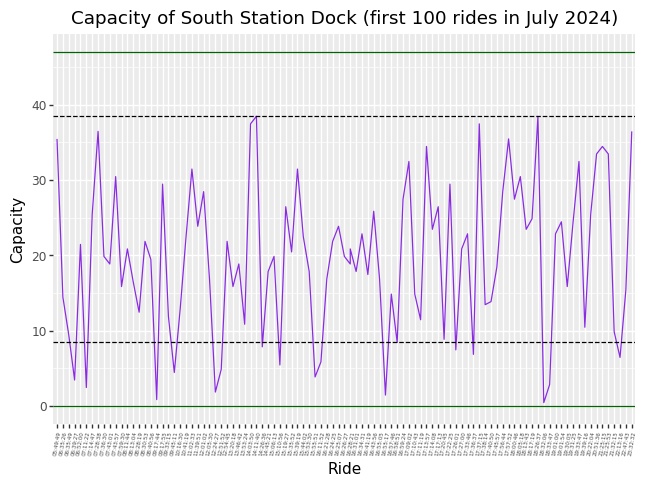

In [ ]:
plot2